In [63]:
import sep
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.wcs import WCS
from astroquery.gaia import Gaia
from matplotlib.patches import Circle

In [106]:
def subtract_background(fits_file, output_directory, bw, bh, fw, fh):
    """
    Выполняет вычитание фона из данных FITS файла и сохраняет результат.

    Параметры:
    fits_file : str
        Путь к входному FITS файлу.
    output_directory : str
        Путь к выходному каталогу для сохранения обработанных файлов.
    bw : int
        Ширина блока для оценки фона.
    bh : int
        Высота блока для оценки фона.
    fw : int
        Ширина фильтра для сглаживания фона.
    fh : int
        Высота фильтра для сглаживания фона.

    Возвращаемые значения:
    data_sub : ndarray
        Данные с вычитанным фоном.
    bkg : sep.Background
        Объект фона.
    header : astropy.io.fits.Header
        Заголовок FITS файла.
    """
    print(f"Processing file: {fits_file}")
    with fits.open(fits_file) as hdul:
        data = hdul[0].data
        header = hdul[0].header

    if data is None or data.size == 0:
        print(f"Warning: No data in FITS file {fits_file}")
        return None, None, None

    print(f"Original byte order: {data.dtype.byteorder}")

    data = data.astype(np.float32)

    
    bkg = sep.Background(data, bw=bw, bh=bh, fw=fw, fh=fh)
    data_sub_0 = data - bkg
    
    data_sub = data_sub_0 + abs(np.min(data_sub_0))
    
    data_sub = np.clip(data_sub_0, 0, 65535)  # Обеспечим, чтобы значения не превышали 65535

    # Создание фигуры и осей
    fig, axs = plt.subplots(2, 2, figsize=(12, 10))

    # Initial frame
    axs[0, 0].hist(data.ravel(), bins=256, histtype='step', color='black')
    axs[0, 0].set_title('Initial frame')
    axs[0, 0].set_xlabel('Pixel Value')
    axs[0, 0].set_ylabel('Frequency')

    # Background
    axs[0, 1].hist(bkg.back().ravel(), bins=256, histtype='step', color='black')
    axs[0, 1].set_title('Background')
    axs[0, 1].set_xlabel('Pixel Value')
    axs[0, 1].set_ylabel('Frequency')

    # Distribution with X-Limits after subtraction
    axs[1, 0].hist(data_sub_0.ravel(), bins=256, histtype='step', color='black')
    axs[1, 0].set_title('Distribution after subtraction')
    axs[1, 0].set_xlabel('Pixel Value')
    axs[1, 0].set_ylabel('Frequency')
    axs[1, 0].axvline(np.min(data_sub_0), color='red', linestyle='--')
    axs[1, 0].axvline(0, color='red', linestyle='--')

    # Full Distribution after subtraction
    axs[1, 1].hist(data_sub.ravel(), bins=256, histtype='step', color='black')
    axs[1, 1].set_title('Final image')
    axs[1, 1].set_xlabel('Pixel Value')
    axs[1, 1].set_ylabel('Frequency')

    plt.tight_layout()
    plt.savefig('pixel_distribution_comparison.png', dpi=300)
    plt.show()

    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    img0 = axs[0].imshow(data, cmap='gray', origin='lower')
    axs[0].set_title('Initial data')
    fig.colorbar(img0, ax=axs[0])

    img1 = axs[1].imshow(data_sub, cmap='gray', origin='lower')
    axs[1].set_title('Data after Background Subtraction')
    fig.colorbar(img1, ax=axs[1])

    img2 = axs[2].imshow(bkg.back(), cmap='gray', origin='lower')
    axs[2].set_title('Background')
    fig.colorbar(img2, ax=axs[2])

    plt.tight_layout()
    plt.show()

    base_name = os.path.splitext(os.path.basename(fits_file))[0]
    output_fits_file = os.path.join(output_directory, f"{base_name}_subtracted.fits")
    hdu = fits.PrimaryHDU(data_sub, header=header)
    hdu.writeto(output_fits_file, overwrite=True)
    
    output_fits_file_bg = os.path.join(output_directory, f"{base_name}_background.fits")
    hdu = fits.PrimaryHDU(bkg.back(), header=header)
    hdu.writeto(output_fits_file_bg, overwrite=True)

    return data_sub, bkg, header

def extract_and_export_objects(data_sub, bkg, header, output_directory, fits_file, subtract_bg=True, bw=, bh, fw, fh):
    """
    Извлекает объекты из данных с вычитанным фоном и сохраняет их параметры в CSV файл.

    Параметры:
    data_sub : ndarray
        Данные с вычитанным фоном.
    bkg : sep.Background
        Объект фона.
    header : astropy.io.fits.Header
        Заголовок FITS файла.
    output_directory : str
        Путь к выходному каталогу для сохранения обработанных файлов.
    fits_file : str
        Путь к исходному FITS файлу для сохранения имени.

    Возвращаемые значения:
    df : pandas.DataFrame
        Таблица с параметрами объектов.
    """
    
    if data_sub is None or bkg is None or header is None:
        print("Invalid input data.")
        return None
    
    if subtract_bg==True:
        data_sub = subtract_background(fits_file, output_directory, bw, bh, fw, fh)

    thresh = 5.0
    minarea = 20
    err = bkg.globalrms

    deblend_nthresh = 32
    deblend_cont = 0.5
    clean = True
    clean_param = 1.0
    
    sep.set_extract_pixstack(1e7) 
    
    objects = sep.extract(data_sub, thresh, err=err, minarea=minarea, deblend_nthresh=deblend_nthresh,
                          deblend_cont=deblend_cont, clean=clean, clean_param=clean_param)

    if len(objects) == 0:
        print(f"No objects found in {fits_file}")
        return None
    else:
        print(f"{len(objects)} objects found in {fits_file}")

    wcs = WCS(header)
    objects_coords = wcs.all_pix2world(objects['x'], objects['y'], 1)

    flux, flux_err, flag = sep.sum_circle(data_sub, objects['x'], objects['y'], 3.0, err=err, gain=1.0)
    mag = -2.5 * np.log10(flux)
    mag_err = 2.5 / np.log(10) * (flux_err / flux)

    df = pd.DataFrame({
        'id': range(len(objects)),
        'x': objects['x'],
        'y': objects['y'],
        'ra': objects_coords[0],
        'dec': objects_coords[1],
        'flux': flux,
        'flux_err': flux_err,
        'mag': mag,
        'mag_err': mag_err,
        'flag': flag
    })

    base_name = os.path.splitext(os.path.basename(fits_file))[0]
    output_csv_file = os.path.join(output_directory, f"{base_name}_objects.csv")
    df.to_csv(output_csv_file, index=False)

    return df

In [174]:
# Открываем FITS файл
file_path = os.getcwd() + '/data/' + 'alf-Cyg_11-12.11.1985_40m_70S-4.fit'
output_directory = os.getcwd()
fits_file = fits.open(file_path)
header = fits_file[0].header
data = fits_file[0].data

In [176]:
# Создаем WCS объект
wcs = WCS(header)

# Определяем размер изображения
naxis1 = header['NAXIS1']
naxis2 = header['NAXIS2']

# Получаем угловые координаты углов изображения
corners = np.array([
    [0, 0],
    [0, naxis2 - 1],
    [naxis1 - 1, 0],
    [naxis1 - 1, naxis2 - 1]
])

# Преобразуем координаты углов в экваториальные координаты (RA, Dec)
ra_dec_corners = wcs.all_pix2world(corners, 1)
ra_values = ra_dec_corners[:, 0]
dec_values = ra_dec_corners[:, 1]

# Определяем минимальные и максимальные значения по RA и Dec
ra_min, ra_max = np.min(ra_values), np.max(ra_values)
dec_min, dec_max = np.min(dec_values), np.max(dec_values)

# Вычисляем разницу
ra_diff = round(ra_max - ra_min,3)
dec_diff = round(dec_max - dec_min,3)

# Выбираем большее значение как радиус в градусах
radius = max(ra_diff, dec_diff) / 2

# Выводим результаты
print(f"RA min: {ra_min}, RA max: {ra_max}, RA diff: {ra_diff} degrees")
print(f"Dec min: {dec_min}, Dec max: {dec_max}, Dec diff: {dec_diff} degrees")
print(f"Selected radius: {radius} degrees")

RA min: 307.1944112379242, RA max: 319.1391869710786, RA diff: 11.945 degrees
Dec min: 42.054666013252074, Dec max: 47.775977877652565, Dec diff: 5.721 degrees
Selected radius: 5.9725 degrees


In [178]:
# Исправляем порядок байтов в массиве данных
data = data.byteswap().newbyteorder().astype(np.float32)

# Вычисляем фон
bkg = sep.Background(data)
data_sub = data - bkg

# Извлекаем объекты и сохраняем их параметры
objects_df = extract_and_export_objects(data_sub, bkg, header, output_directory, file_path)
objects_df.to_csv("pleadies.csv", index=False)

2971 objects found in /Users/ildana/astro/fai/variable_search/data/alf-Cyg_11-12.11.1985_40m_70S-4.fit


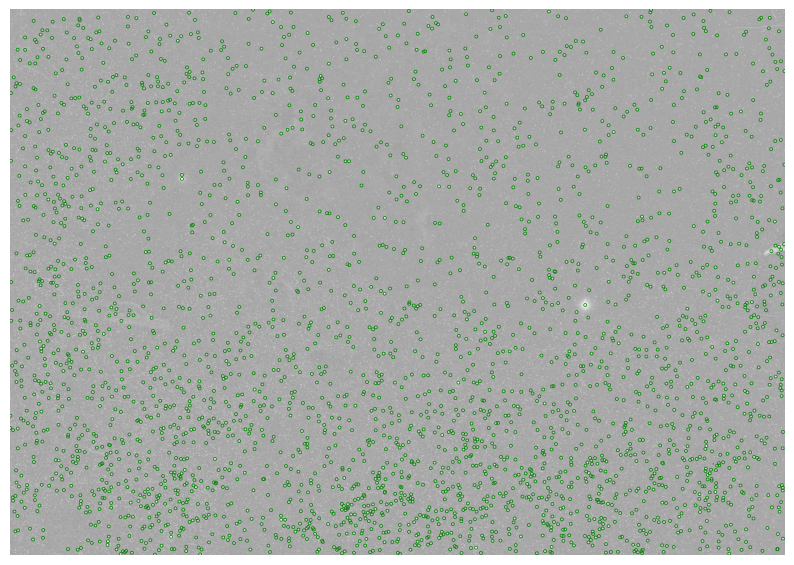

In [182]:
# Создаем фигуру и ось
fig, ax = plt.subplots(figsize=(10, 10))

# Отображаем изображение
ax.imshow(data_sub, cmap='gray', origin='lower')

# Добавляем окружности для каждого объекта
for index, obj in objects_df.iterrows():
    circ = Circle((float(obj['x']), float(obj['y'])), radius=10, lw=0.5, edgecolor='green', facecolor='none')
    ax.add_patch(circ)

# Отключаем оси
ax.axis('off')

# Показываем график
plt.show()

In [184]:
# Пример запроса к каталогу Gaia для заданной области неба
query = """
SELECT TOP 1000000
    source_id, ra, dec, pmra, pmdec, parallax
FROM gaiadr3.gaia_source
WHERE CONTAINS(
    POINT('ICRS', ra, dec),
    CIRCLE('ICRS', {ra}, {dec}, {radius})
) = 1
"""

# Используем центральные координаты вашего изображения и радиус
ra_center = header['CRVAL1']
dec_center = header['CRVAL2']
radius = round(radius,1)  # Радиус области в градусах

# Выполняем запрос
job = Gaia.launch_job(query.format(ra=ra_center, dec=dec_center, radius=radius))
gaia_data = job.get_results()

# Преобразуем данные в DataFrame для удобства
gaia_df = gaia_data.to_pandas()
len(gaia_df)

1000000

In [185]:
# Сопоставление координат звезд из FITS-файла с каталогом Gaia
def match_stars(objects_df, gaia_df, max_dist=radius*.1):
    matches = []
    for index, star in objects_df.iterrows():
        ra, dec = star['ra'], star['dec']
        distances = np.sqrt((gaia_df['ra'] - ra)**2 + (gaia_df['dec'] - dec)**2)
        min_dist = distances.min()
        if min_dist < max_dist:
            matched_star = gaia_df.iloc[distances.idxmin()]
            matches.append({
                'x': star['x'],
                'y': star['y'],
                'ra_diff': ra - matched_star['ra'],
                'dec_diff': dec - matched_star['dec']
            })
    return pd.DataFrame(matches)

matched_stars_df = match_stars(objects_df, gaia_df)
len(matched_stars_df)

673

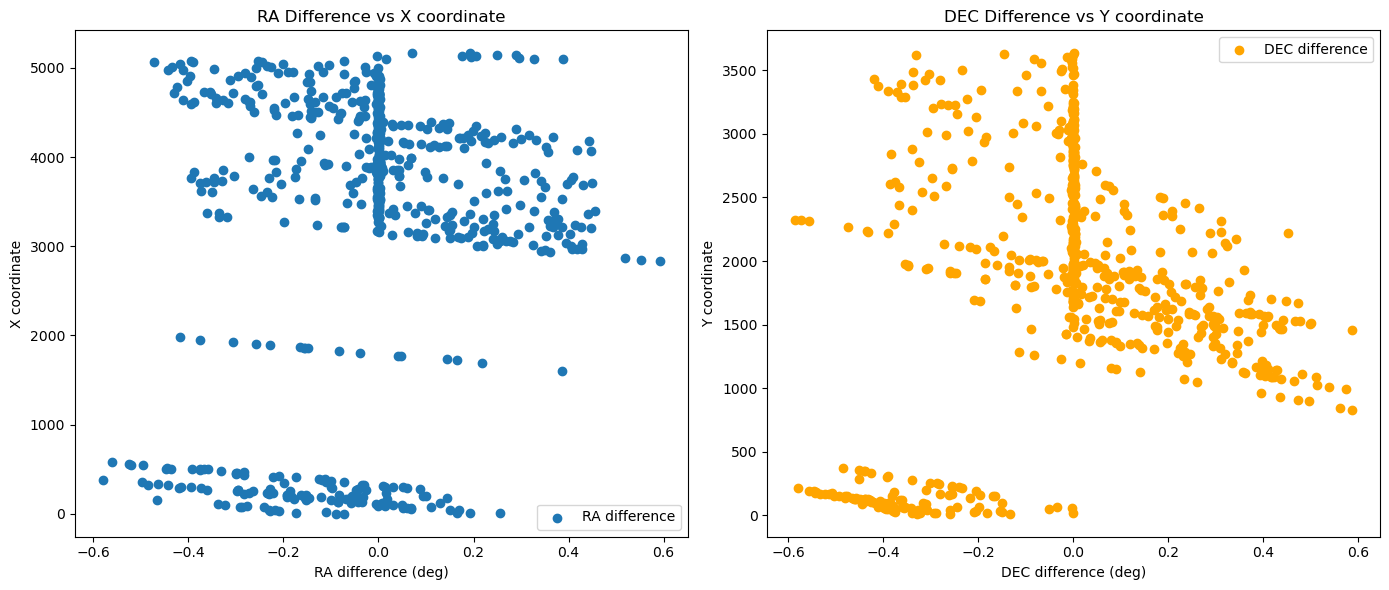

In [190]:
# Построение диаграмм
plt.figure(figsize=(14, 6))

# Диаграмма разницы в прямом восхождении
plt.subplot(1, 2, 1)
plt.scatter(matched_stars_df['ra_diff'], matched_stars_df['x'],  label='RA difference')
plt.ylabel('X coordinate')
plt.xlabel('RA difference (deg)')
plt.title('RA Difference vs X coordinate')
plt.legend()

# Диаграмма разницы в склонении
plt.subplot(1, 2, 2)
plt.scatter( matched_stars_df['dec_diff'],matched_stars_df['y'], label='DEC difference', color='orange')
plt.ylabel('Y coordinate')
plt.xlabel('DEC difference (deg)')
plt.title('DEC Difference vs Y coordinate')
plt.legend()

plt.tight_layout()
plt.show()

In [196]:
np.median(abs(matched_stars_df['ra_diff']))*60

6.129457045360596